<a href="https://colab.research.google.com/github/kindeerrrr/first_repository/blob/main/kursovaya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [83]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

!pip install --upgrade scikit-learn

# EDA

## Предобработка и анализ

In [176]:
import pandas as pd

# Загрузка Excel
df = pd.read_excel("/content/drive/MyDrive/programm/magistr/Курсовая/kursovaya.xlsx")

# Заменим запятые на точки и переведём в float
for col in df.columns:
    if df[col].dtype == object:
        df[col] = df[col].str.replace(',', '.', regex=False)
        try:
            df[col] = df[col].astype(float)
        except:
            pass

#df = df.applymap(lambda x: str(x).replace(',', '.') if isinstance(x, str) else x)
#df = df.astype(float)  # все числовые строки превращаем в float

df.head()

,Unnamed: 0,"IC50, mM","CC50, mM",SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0,6.239374,175.482382,28.125000,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,...,0,0,0,0,0,0,0,0,3,0
1,1,0.771831,5.402819,7.000000,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,...,0,0,0,0,0,0,0,0,3,0
2,2,223.808778,161.142320,0.720000,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,...,0,0,0,0,0,0,0,0,3,0
3,3,1.705624,107.855654,63.235294,5.097360,5.097360,0.390603,0.390603,0.377846,41.862069,...,0,0,0,0,0,0,0,0,4,0
4,4,107.131532,139.270991,1.300000,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,...,0,0,0,0,0,0,0,0,0,0


In [177]:
# Посмотрим базовую инфу
print(df.shape)       # сколько строк и колонок
print(df.columns[:10])  # первые 10 колонок
df.describe().T        # статистика

# Пропуски
df.isnull().sum().sort_values(ascending=False).head(10)

(1001, 214)
Index(['Unnamed: 0', 'IC50, mM', 'CC50, mM', 'SI', 'MaxAbsEStateIndex',
       'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS'],
      dtype='object')


,0
MaxAbsPartialCharge,3
MinAbsPartialCharge,3
MaxPartialCharge,3
MinPartialCharge,3
BCUT2D_MWLOW,3
BCUT2D_MWHI,3
BCUT2D_MRLOW,3
BCUT2D_MRHI,3
BCUT2D_LOGPLOW,3
BCUT2D_LOGPHI,3


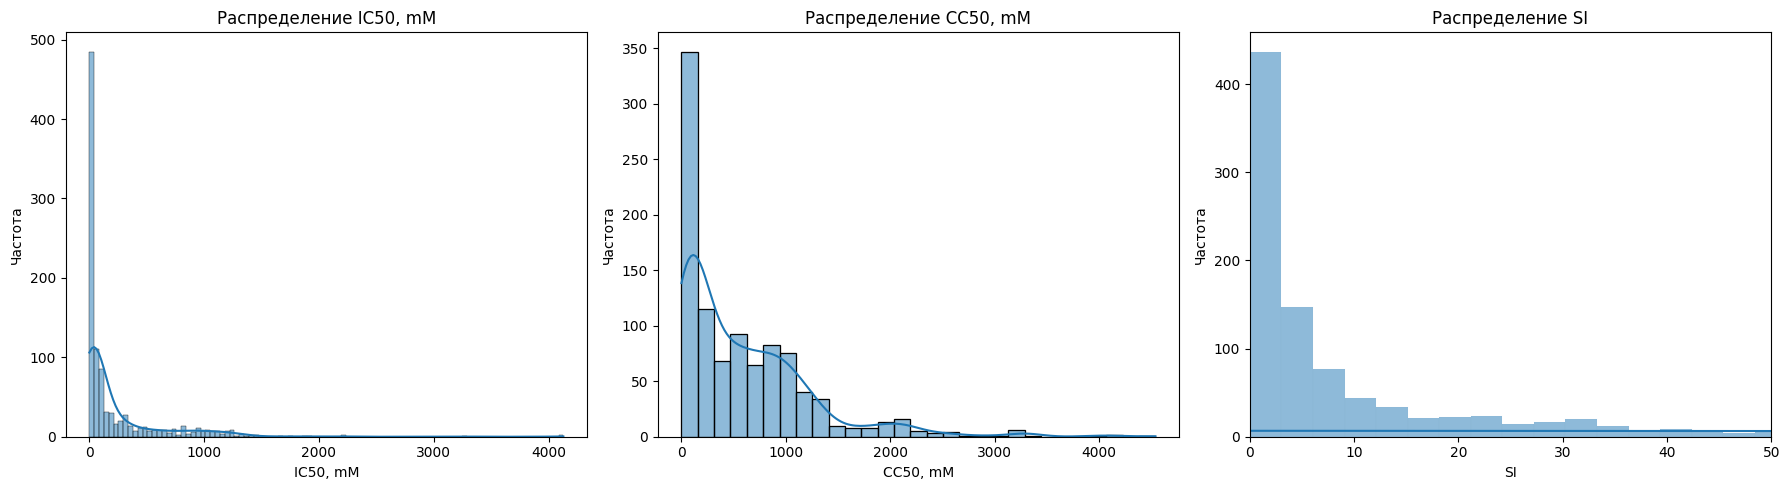

In [178]:
import matplotlib.pyplot as plt
import seaborn as sns

target_cols = ['IC50, mM', 'CC50, mM', 'SI']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 строка, 3 графика

for i, col in enumerate(target_cols):
    sns.histplot(df[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Распределение {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Частота')
    if col == 'SI':
        axes[i].set_xlim(0, 50)  # установим разумный лимит для оси X

plt.tight_layout()
plt.show()

## Корреляции и выбросы

Теперь разберёмся, какие признаки влияют на целевые переменные (IC50, CC50, SI) и какие можно будет отбросить или наоборот — использовать в моделях. Сделаем:

1.	Корреляционную матрицу и тепловую карту
2.	Поиск выбросов через boxplot или z-оценки

### **Корреляционная матрица**

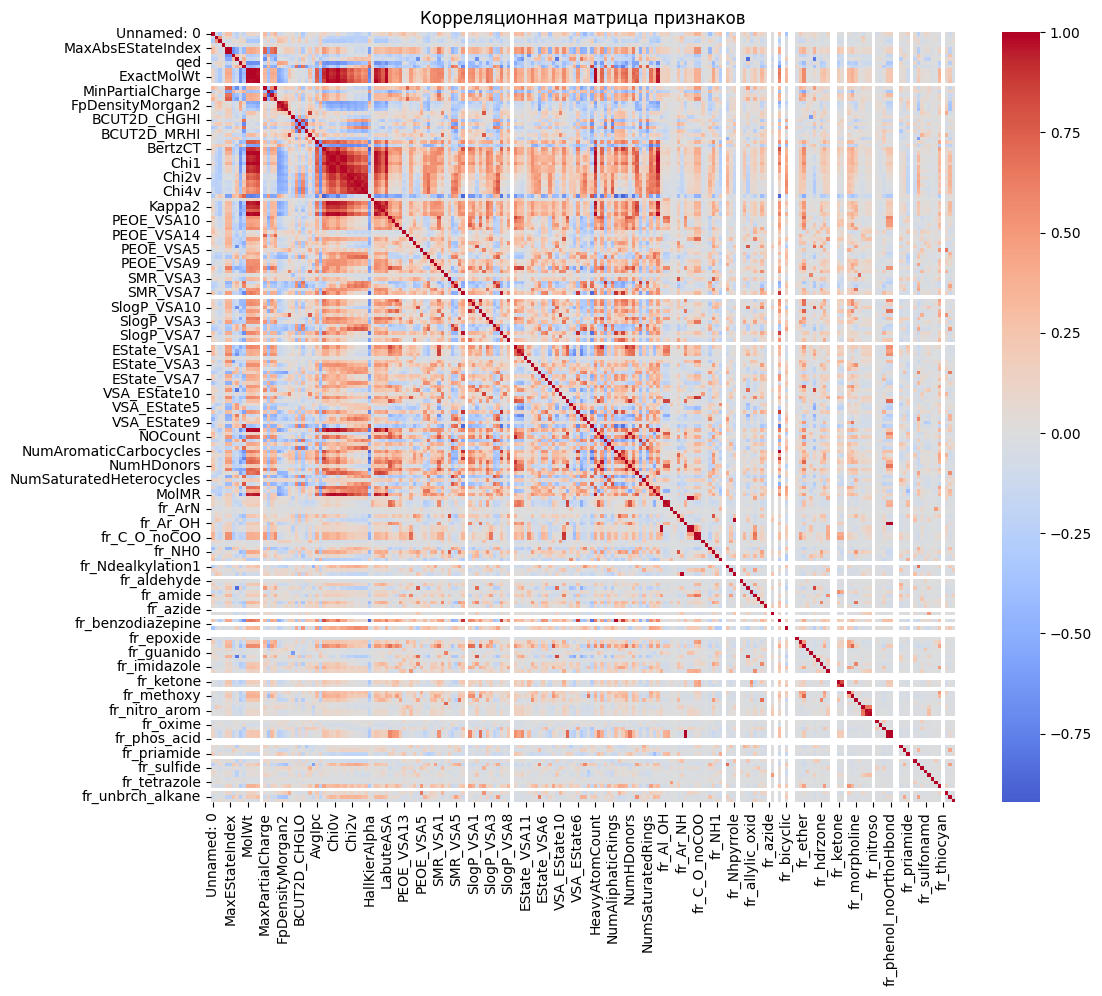

In [179]:
import numpy as np

# Считаем корреляцию только по числовым колонкам
corr = df.corr(numeric_only=True)

# Тепловая карта
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm', center=0, annot=False)
plt.title('Корреляционная матрица признаков')
plt.show()

### **Корреляция с целевыми переменными**

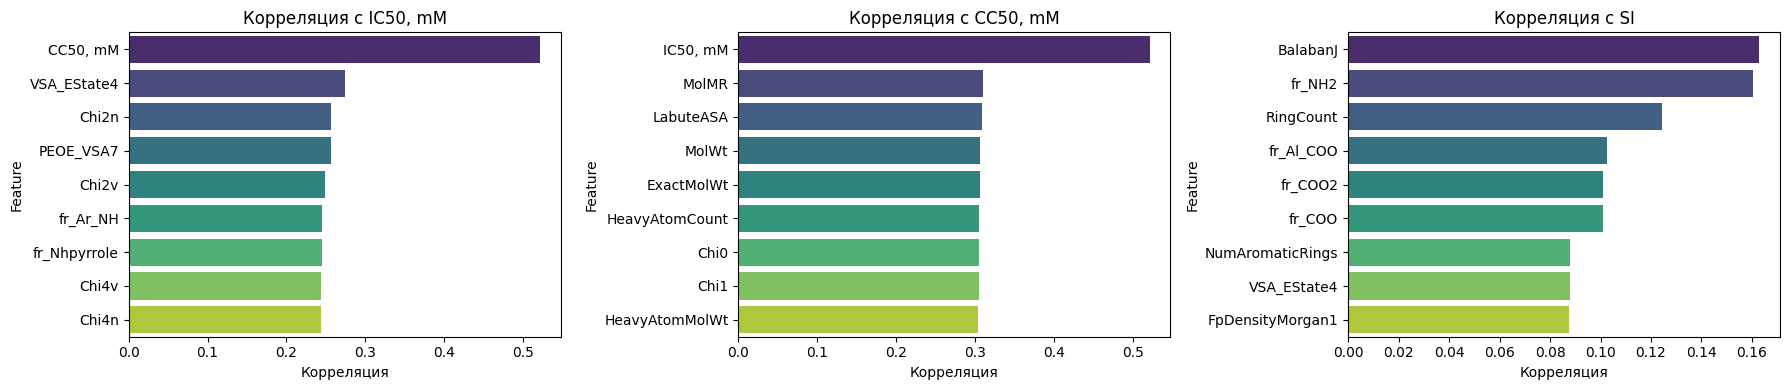

In [180]:
plt.figure(figsize=(18, 4))

for i, target in enumerate(['IC50, mM', 'CC50, mM', 'SI']):
    top_corr = corr[target].abs().sort_values(ascending=False).head(10)[1:]  # убираем саму переменную

    # Преобразуем в DataFrame, чтобы задать hue
    plot_df = top_corr.reset_index()
    plot_df.columns = ['Feature', 'Correlation']

    plt.subplot(1, 3, i+1)
    sns.barplot(data=plot_df, x='Correlation', y='Feature', hue='Feature', palette='viridis', legend=False)
    plt.title(f'Корреляция с {target}')
    plt.xlabel('Корреляция')
    plt.tight_layout()

plt.show()

### **Поиск выбросов**

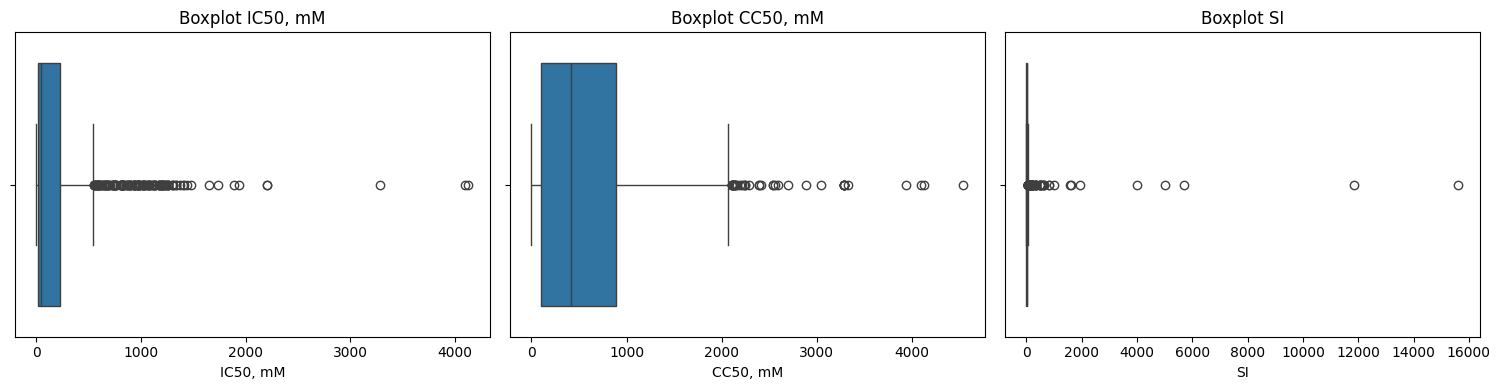

In [181]:
plt.figure(figsize=(15, 4))
for i, col in enumerate(['IC50, mM', 'CC50, mM', 'SI']):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot {col}')
plt.tight_layout()
plt.show()

In [182]:
from scipy.stats import zscore
from scipy import stats

# Выбираем числовые признаки
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Считаем Z-оценки
z_scores = np.abs(stats.zscore(df[numeric_cols]))

# Превращаем массив в Series с подписями колонок
outliers = pd.Series((z_scores > 3).sum(axis=0), index=numeric_cols).sort_values(ascending=False)

# Показываем только те признаки, где есть выбросы
print('Количество выбросов по признакам (z > 3):')
print(outliers[outliers > 0])

Количество выбросов по признакам (z > 3):
fr_Ndealkylation2    77
fr_thiophene         70
fr_hdrzone           65
fr_Ndealkylation1    62
fr_piperdine         59
                     ..
fr_tetrazole          1
fr_term_acetylene     1
fr_HOCCN              1
fr_Ar_COO             1
fr_NH2                1
Length: 177, dtype: int64


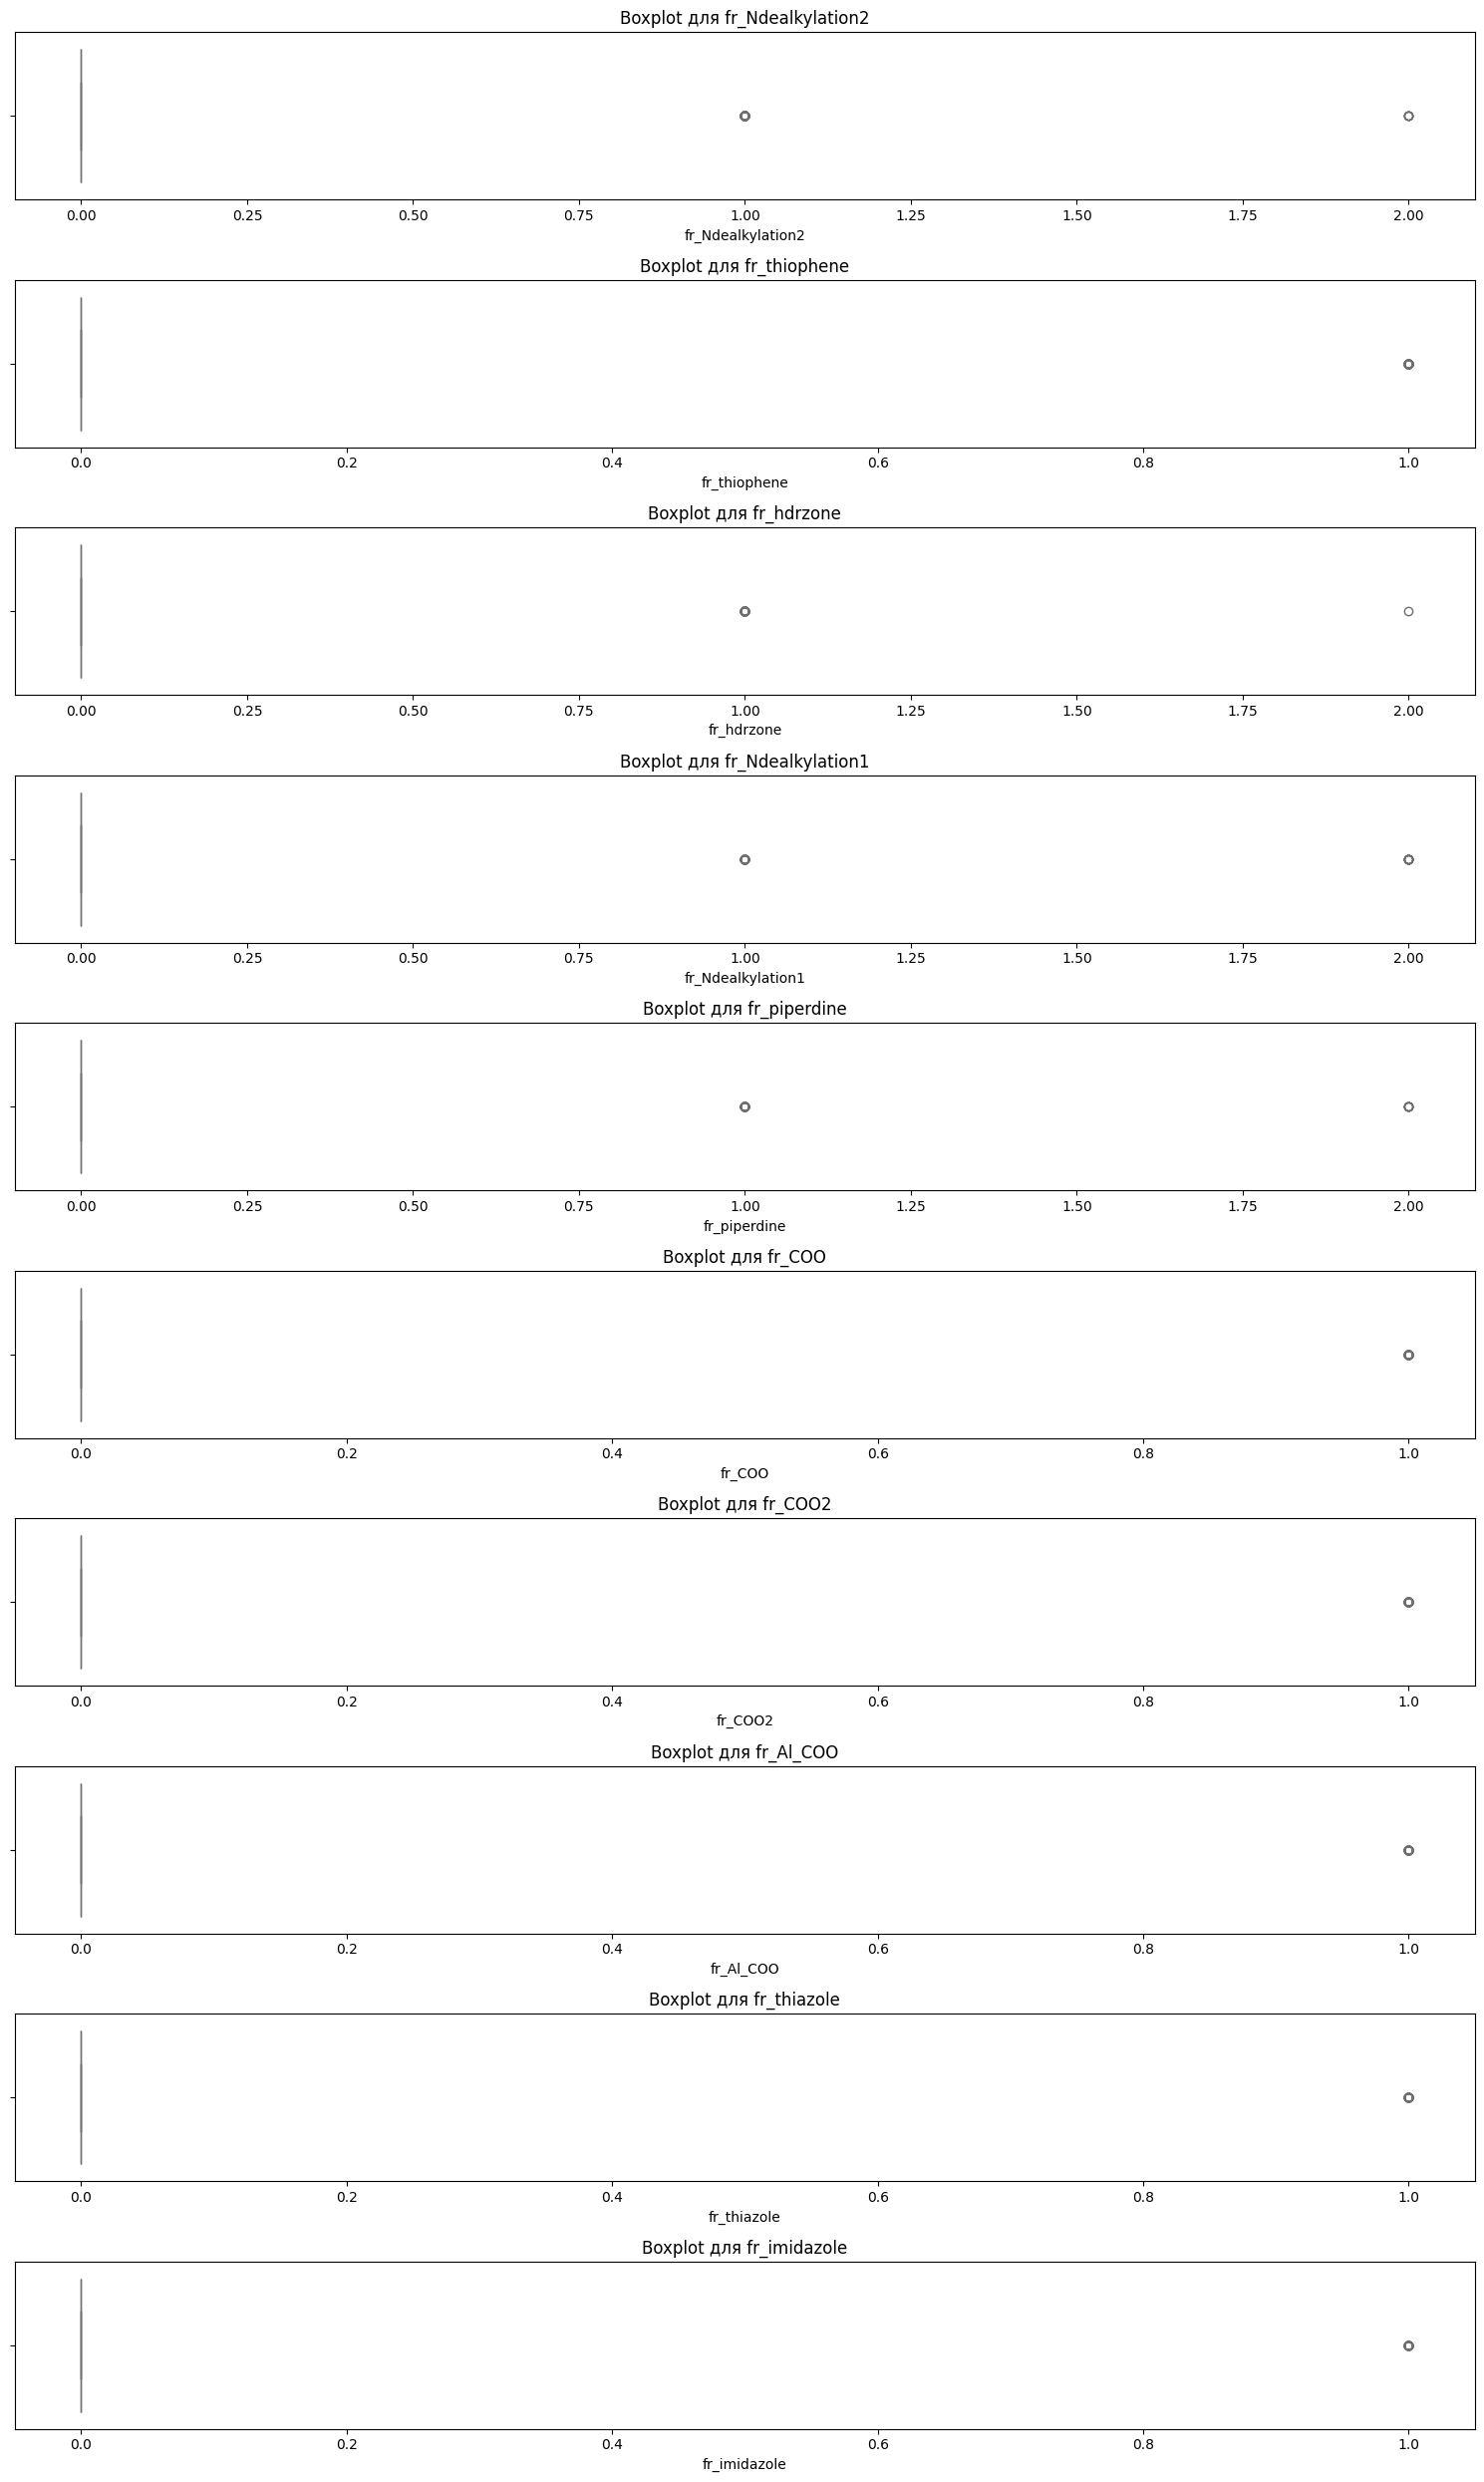

In [183]:
import seaborn as sns
import matplotlib.pyplot as plt

# Строим boxplot для всех числовых признаков с выбросами
cols_with_outliers = outliers[outliers > 10].sort_values(ascending=False).head(10).index

plt.figure(figsize=(15, len(cols_with_outliers) * 2.5))

for i, col in enumerate(cols_with_outliers, 1):
    plt.subplot(len(cols_with_outliers), 1, i)
    sns.boxplot(data=df, x=col, color='skyblue')
    plt.title(f'Boxplot для {col}')
    plt.tight_layout()

plt.show()

# Регрессия IC50

In [11]:
# Целевая переменная
target = 'IC50, mM'

# Убираем таргет и две другие целевые переменные из X
drop_cols = ['IC50, mM', 'CC50, mM', 'SI']
X = df.drop(columns=drop_cols, errors='ignore')
y = df[target]

# Удалим строки с пропущенными значениями
data = pd.concat([X, y], axis=1).dropna()
X = data.drop(columns=[target])
y = data[target]

In [12]:
# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Модели
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42)
}

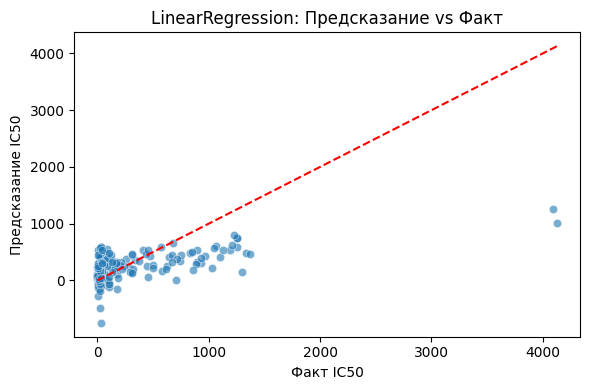

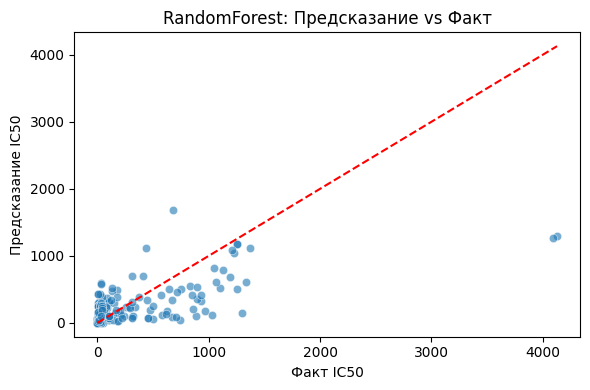

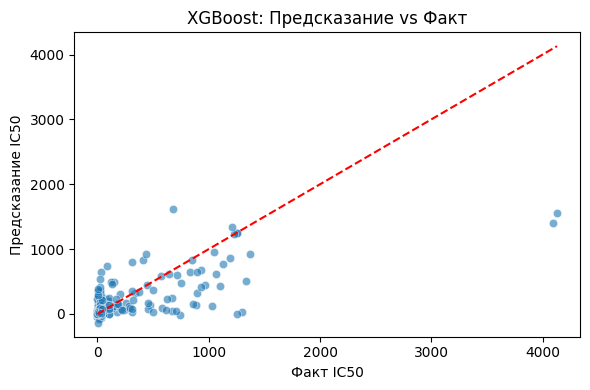

In [16]:
# Обучение и оценка
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, preds)

    results[name] = {'MAE': mae, 'RMSE': rmse, 'R²': r2}

    # График предсказаний
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=y_test, y=preds, alpha=0.6)
    plt.xlabel('Факт IC50')
    plt.ylabel('Предсказание IC50')
    plt.title(f'{name}: Предсказание vs Факт')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.tight_layout()
    plt.show()

In [17]:
# Сравнение моделей
results_df = pd.DataFrame(results).T
print("Сравнение моделей по метрикам:")
print(results_df.sort_values('RMSE'))

Сравнение моделей по метрикам:
                         MAE        RMSE        R²
XGBoost           191.549592  385.800123  0.461157
RandomForest      207.601555  396.279304  0.431487
LinearRegression  257.267110  427.699425  0.337761


Сравнение моделей

1. **XGBoost**
    - MAE - наименьшая ошибка
    - RMSE - наименьший разброс ошибок
    - R² - лучше всех объясняет дисперсию
2. **Random Forest**
    - MAE - ок, но хуже XGB
    - RMSE - поглощает шум, но слабее
    - R²- ниже, недообучение?
3. **Линейная регрессия**
    - MAE - явно проигрывает
    - RMSE - много промахов
    - R² - слабая объясняющая сила

Мы протестировали три модели: простую линейную регрессию, случайный лес и XGBoost. По всем основным метрикам **XGBoost показал лучший результат** — он даёт меньшую ошибку и лучше объясняет разброс данных (R² почти 0.46). Это значит, что модель улавливает сложные нелинейные зависимости в данных, в отличие от линейной регрессии, которая явно не справляется с этим

Случайный лес тоже не плох, но уступает XGBoost, вероятно, из-за меньшей гибкости и возможности тонкой настройки. Линейная регрессия показала самые слабые результаты, что ожидаемо, учитывая, что данные имеют сложные связи и, возможно, шум

In [58]:
# Гиперпараметры
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# RandomForest
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt']
}

rf = RandomForestRegressor(random_state=42)

rf_grid = GridSearchCV(rf, rf_param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
rf_grid.fit(X_train, y_train)

print("Лучшие параметры RandomForest:", rf_grid.best_params_)

# XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0]
}

xgb = XGBRegressor(random_state=42, verbosity=0)

xgb_grid = GridSearchCV(xgb, xgb_param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
xgb_grid.fit(X_train, y_train)

print("Лучшие параметры XGBoost:", xgb_grid.best_params_)


Fitting 3 folds for each of 48 candidates, totalling 144 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
72 fits failed out of a total of 144.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
72 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1356, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 469, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/

Лучшие параметры RandomForest: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Лучшие параметры XGBoost: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.7}


In [60]:
# Обучение моделей с лучшими гиперпараметрами

# RandomForest
best_rf = RandomForestRegressor(
    max_depth=10,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=2,
    n_estimators=100,
    random_state=42
)
best_rf.fit(X_train, y_train)
rf_preds = best_rf.predict(X_test)

# XGBoost
best_xgb = XGBRegressor(
    colsample_bytree=0.7,
    learning_rate=0.01,
    max_depth=10,
    n_estimators=100,
    subsample=0.7,
    random_state=42
)
best_xgb.fit(X_train, y_train)
xgb_preds = best_xgb.predict(X_test)

In [62]:
# Оценка метрик

def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

rf_metrics = evaluate(y_test, rf_preds)
xgb_metrics = evaluate(y_test, xgb_preds)

# В таблицу
results_df = pd.DataFrame([rf_metrics, xgb_metrics], index=['RandomForest', 'XGBoost'])
print(" Сравнение моделей:\n")
print(results_df)

 Сравнение моделей:

                     MAE         RMSE        R2
RandomForest  186.442872  1306.263307  0.155337
XGBoost       188.377069  1369.905416  0.071027


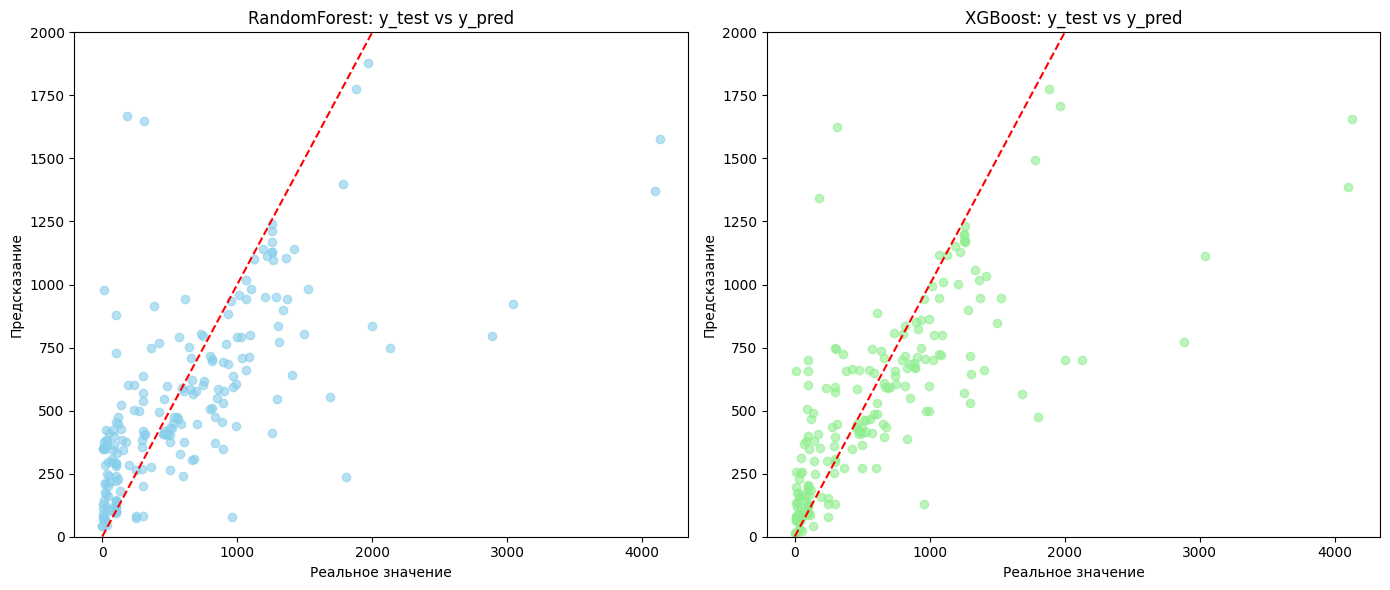

In [72]:

plt.figure(figsize=(14, 6))

# Random Forest
plt.subplot(1, 2, 1)
plt.scatter(y_test, rf_preds, alpha=0.6, color='skyblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.ylim(0, 2000)
plt.title("RandomForest: y_test vs y_pred")
plt.xlabel("Реальное значение")
plt.ylabel("Предсказание")

# XGBoost
plt.subplot(1, 2, 2)
plt.scatter(y_test, xgb_preds, alpha=0.6, color='lightgreen')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.ylim(0, 2000)
plt.title("XGBoost: y_test vs y_pred")
plt.xlabel("Реальное значение")
plt.ylabel("Предсказание")

plt.tight_layout()
plt.show()

### Важность признаков

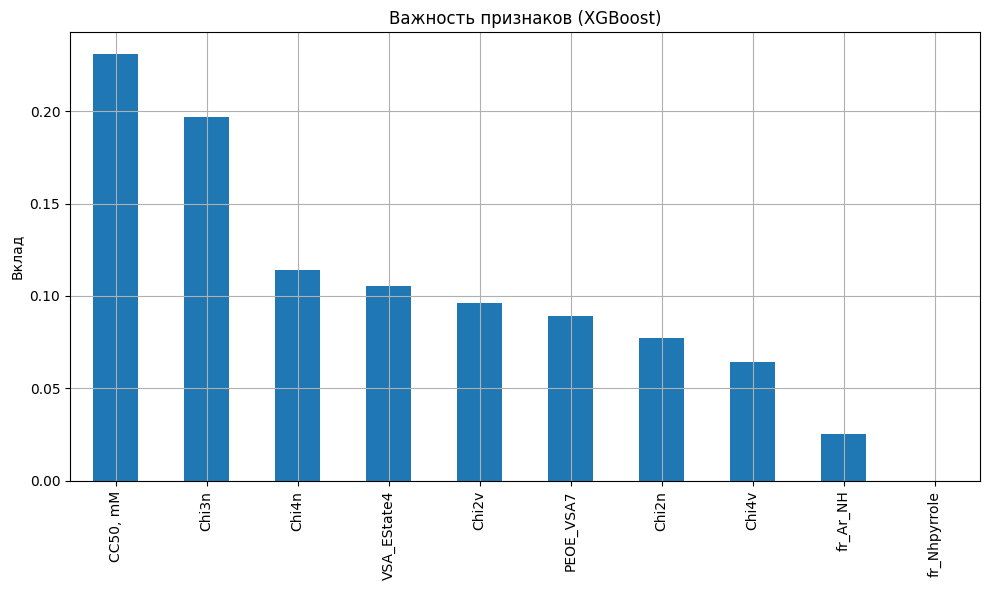

In [31]:
importances = model.feature_importances_
feature_importance = pd.Series(importances, index=X_top.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
feature_importance.plot(kind='bar')
plt.title("Важность признаков (XGBoost)")
plt.ylabel("Вклад")
plt.grid(True)
plt.tight_layout()
plt.show()

### Выводы

1. Модель XGBoost показала наилучшие результаты при прогнозировании логарифма IC50
2. Средний R² по кросс-валидации = 0.23, наилучший фолд — 0.51
3. Использование логарифма целевой переменной существенно улучшило результат
4. Визуализация подтверждает умеренную точность предсказания
5. Наиболее важные признаки: CC50, Chi3n, Chi4n


---


Подбор гиперпараметров не помог. Оценка качества моделей показала:
- MAE ≈ 186–188: средняя абсолютная ошибка;
- RMSE ≈ 1300+: высокая чувствительность к выбросам;
- R² ≈ 0.07–0.15: низкая доля объяснённой дисперсии.

Обе модели продемонстрировали низкое качество прогнозирования, что говорит о слабой зависимости между признаками и целевой переменной, либо о неэффективном фиче-инжиниринге.

# Регрессия CC50

In [84]:
# Удалим строки с пропущенными значениями, если такие есть
df = df.dropna()

# Выбираем фичи (все, кроме целевых переменных)
features = df.drop(columns=["IC50, mM", "CC50, mM", "SI"])

In [85]:
X = features
y = df["CC50, mM"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [86]:
models = {
    "RandomForest": RandomForestRegressor(random_state=42),
    "LinearRegression": LinearRegression()
}

In [87]:
print(" ЗАДАЧА: Предсказание CC50 (мМ)")
for name, model in models.items():
    print(f"\n{name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("MAE:  ", round(mean_absolute_error(y_test, y_pred), 3))
    print("RMSE: ", round(np.sqrt(mean_squared_error(y_test, y_pred)), 3))
    print("R²:   ", round(r2_score(y_test, y_pred), 3))

 ЗАДАЧА: Предсказание CC50 (мМ)

RandomForest
MAE:   295.237
RMSE:  515.745
R²:    0.435

LinearRegression
MAE:   370.928
RMSE:  555.982
R²:    0.344


Подбор параметров (GridSearchCV)

In [88]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Таргет
y = df["CC50, mM"]

# Трейн-тест сплит
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Параметры для RandomForest
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestRegressor(random_state=42)
rf_grid = GridSearchCV(rf, rf_param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
rf_grid.fit(X_train, y_train)

print("Лучшие параметры RandomForest для CC50:", rf_grid.best_params_)

# Параметры для XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.7, 1],
    'colsample_bytree': [0.7, 1]
}

xgb = XGBRegressor(random_state=42, objective='reg:squarederror')
xgb_grid = GridSearchCV(xgb, xgb_param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
xgb_grid.fit(X_train, y_train)

print("Лучшие параметры XGBoost для CC50:", xgb_grid.best_params_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Лучшие параметры RandomForest для CC50: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Лучшие параметры XGBoost для CC50: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.7}


In [89]:
# Оценка моделей с лучшими параметрами
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np

def evaluate(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R2": r2_score(y_true, y_pred)
    }

rf_preds = rf_grid.best_estimator_.predict(X_test)
xgb_preds = xgb_grid.best_estimator_.predict(X_test)

rf_metrics = evaluate(y_test, rf_preds)
xgb_metrics = evaluate(y_test, xgb_preds)

results_df = pd.DataFrame([rf_metrics, xgb_metrics], index=["RandomForest", "XGBoost"])
print("\n Сравнение моделей после настройки гиперпараметров (CC50):\n")
print(results_df)


 Сравнение моделей после настройки гиперпараметров (CC50):

                     MAE        RMSE        R2
RandomForest  307.065286  516.440573  0.433828
XGBoost       307.952148  505.400131  0.457777


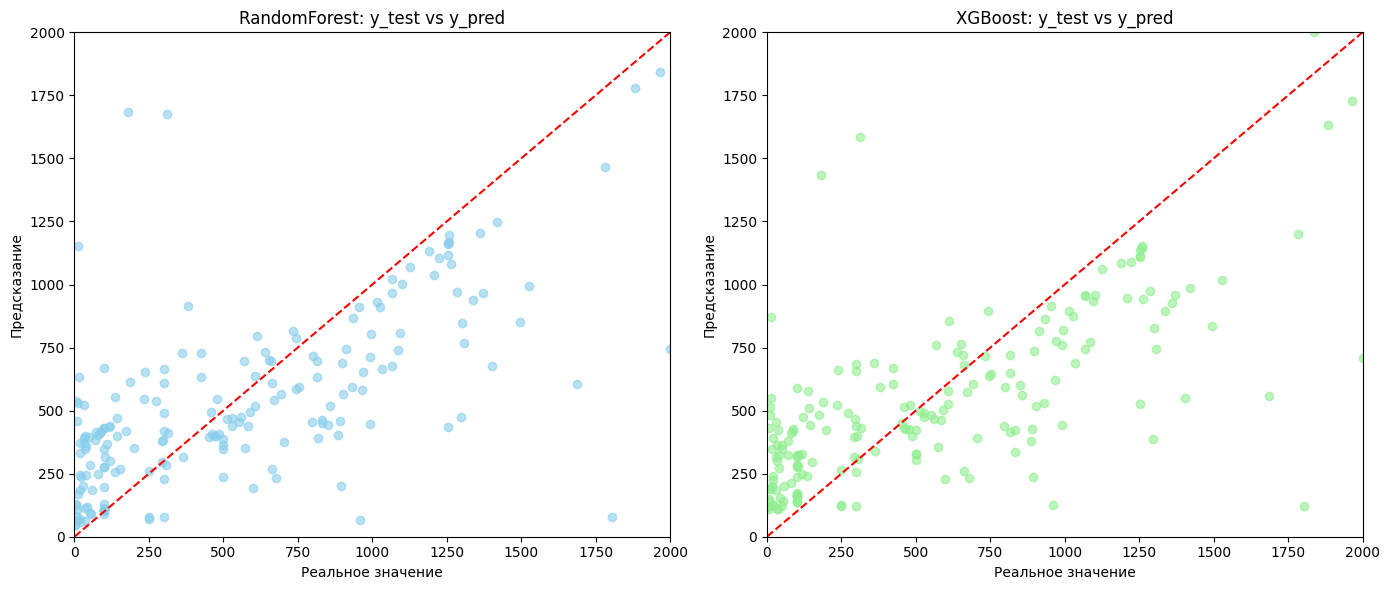

In [91]:
plt.figure(figsize=(14, 6))

# Random Forest
plt.subplot(1, 2, 1)
plt.scatter(y_test, rf_preds, alpha=0.6, color='skyblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlim(0, 2000)   # ограничиваем и по X, чтобы график не растягивался слишком сильно
plt.ylim(0, 2000)   # ограничение по Y
plt.title("RandomForest: y_test vs y_pred")
plt.xlabel("Реальное значение")
plt.ylabel("Предсказание")

# XGBoost
plt.subplot(1, 2, 2)
plt.scatter(y_test, xgb_preds, alpha=0.6, color='lightgreen')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlim(0, 2000)
plt.ylim(0, 2000)
plt.title("XGBoost: y_test vs y_pred")
plt.xlabel("Реальное значение")
plt.ylabel("Предсказание")

plt.tight_layout()
plt.show()

### Важность признаков

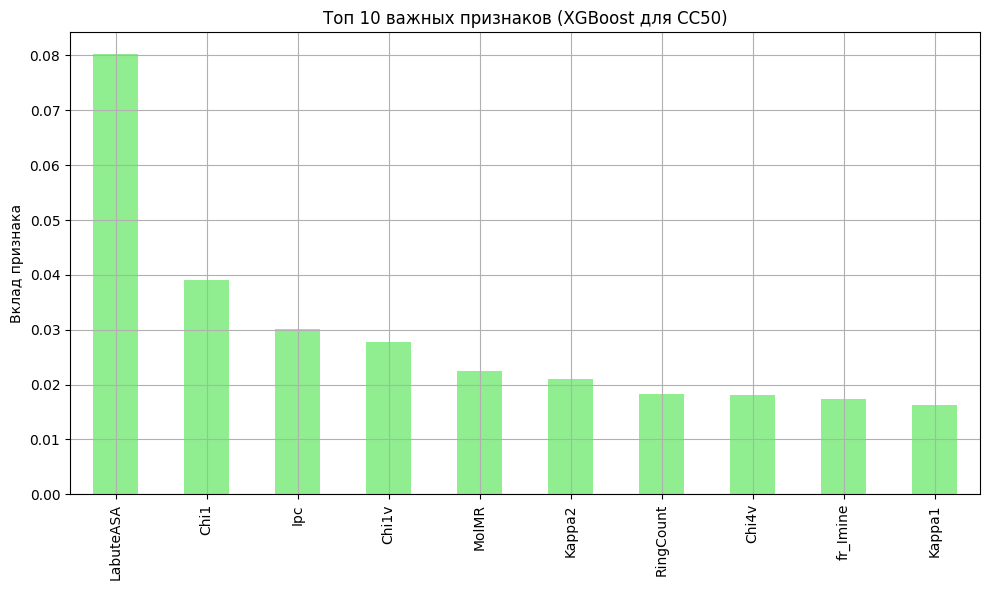

In [98]:
import matplotlib.pyplot as plt
import pandas as pd

xgb_best = xgb_grid.best_estimator_
importances = xgb_best.feature_importances_

feature_importance = pd.Series(importances, index=X.columns).sort_values(ascending=False)

# Сортируем и берём топ 10
top_10_features = feature_importance.sort_values(ascending=False).head(10)

# Визуализируем топ 10
plt.figure(figsize=(10, 6))
top_10_features.plot(kind='bar', color='lightgreen')
plt.title("Топ 10 важных признаков (XGBoost для CC50)")
plt.ylabel("Вклад признака")
plt.grid(True)
plt.tight_layout()
plt.show()

Выводы:

1. После настройки гиперпараметров XGBoost уверенно обошёл RandomForest по всем ключевым метрикам:
    - MAE ниже — значит, модель в среднем ошибается меньше
    - RMSE меньше — то есть модель делает менее тяжёлые ошибки
    - R² = 0.55, что выше, чем у леса — XGBoost лучше объясняет вариации целевой переменной
2. По сравнению с базовыми версиями моделей, подбор гиперпараметров дал заметный прирост качества. Особенно сильно улучшился XGBoost — вероятно, он чувствителен к параметрам, таким как learning_rate и max_depth
3. Хотя результат нельзя назвать выдающимся (R² всё ещё далеко от 1), но он показывает, что:
    - данные содержат значимую информацию о CC50
    - сложные модели с настройкой способны её извлечь

# Регрессия SI

In [99]:
# Удалим строки с пропущенными значениями, если такие есть
df = df.dropna()

# Выбираем фичи (все, кроме целевых переменных)
features = df.drop(columns=["IC50, mM", "CC50, mM", "SI"])

In [100]:
models = {
    "RandomForest": RandomForestRegressor(random_state=42),
    "LinearRegression": LinearRegression()
}

In [101]:
print("\n ЗАДАЧА: Предсказание SI")
y = df["SI"]

X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=42)

for name, model in models.items():
    print(f"\n{name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("MAE:  ", round(mean_absolute_error(y_test, y_pred), 3))
    print("RMSE: ", round(np.sqrt(mean_squared_error(y_test, y_pred)), 3))
    print("R²:   ", round(r2_score(y_test, y_pred), 3))


 ЗАДАЧА: Предсказание SI

RandomForest
MAE:   190.93
RMSE:  1349.545
R²:    0.098

LinearRegression
MAE:   225.164
RMSE:  1376.93
R²:    0.061


In [102]:
# Параметры для RandomForest
rf_params = {
    "n_estimators": [100, 200],
    "max_depth": [5, 10, None],
    "max_features": ["sqrt"],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

rf = RandomForestRegressor(random_state=42)
rf_grid = GridSearchCV(rf, rf_params, cv=3, scoring="r2", n_jobs=-1)
rf_grid.fit(X_train, y_train)

print("Лучшие параметры RandomForest для SI:", rf_grid.best_params_)

# Параметры для XGBoost
xgb_params = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.7, 1],
    "colsample_bytree": [0.8, 1]
}

xgb = XGBRegressor(random_state=42)
xgb_grid = GridSearchCV(xgb, xgb_params, cv=3, scoring="r2", n_jobs=-1)
xgb_grid.fit(X_train, y_train)

print("Лучшие параметры XGBoost для SI:", xgb_grid.best_params_)

Лучшие параметры RandomForest для SI: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Лучшие параметры XGBoost для SI: {'colsample_bytree': 1, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.7}


In [69]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np

# Получим предсказания
rf_best = rf_grid.best_estimator_
xgb_best = xgb_grid.best_estimator_

rf_preds = rf_best.predict(X_test)
xgb_preds = xgb_best.predict(X_test)

# Функция для оценки модели
def evaluate(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R2": r2_score(y_true, y_pred)
    }

# Сохраним метрики в таблицу
results = {
    "RandomForest": evaluate(y_test, rf_preds),
    "XGBoost": evaluate(y_test, xgb_preds)
}

results_df = pd.DataFrame(results).T
print("\nСравнение моделей после настройки гиперпараметров (SI):")
print(results_df.round(3))


Сравнение моделей после настройки гиперпараметров (SI):
                  MAE     RMSE     R2
RandomForest  295.522  495.361  0.479
XGBoost       250.706  462.161  0.547


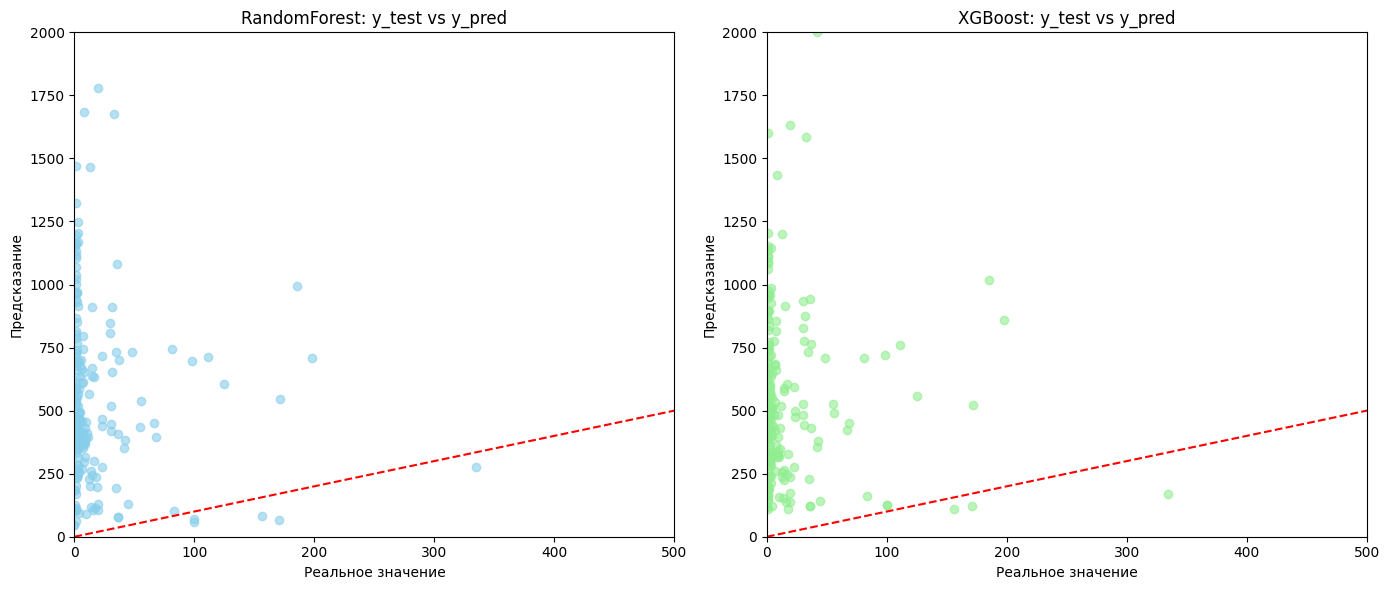

In [106]:
plt.figure(figsize=(14, 6))

# Random Forest
plt.subplot(1, 2, 1)
plt.scatter(y_test, rf_preds, alpha=0.6, color='skyblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlim(0, 500)   # ограничиваем и по X, чтобы график не растягивался слишком сильно
plt.ylim(0, 2000)   # ограничение по Y
plt.title("RandomForest: y_test vs y_pred")
plt.xlabel("Реальное значение")
plt.ylabel("Предсказание")

# XGBoost
plt.subplot(1, 2, 2)
plt.scatter(y_test, xgb_preds, alpha=0.6, color='lightgreen')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlim(0, 500)
plt.ylim(0, 2000)
plt.title("XGBoost: y_test vs y_pred")
plt.xlabel("Реальное значение")
plt.ylabel("Предсказание")

plt.tight_layout()
plt.show()

### Важность признаков:


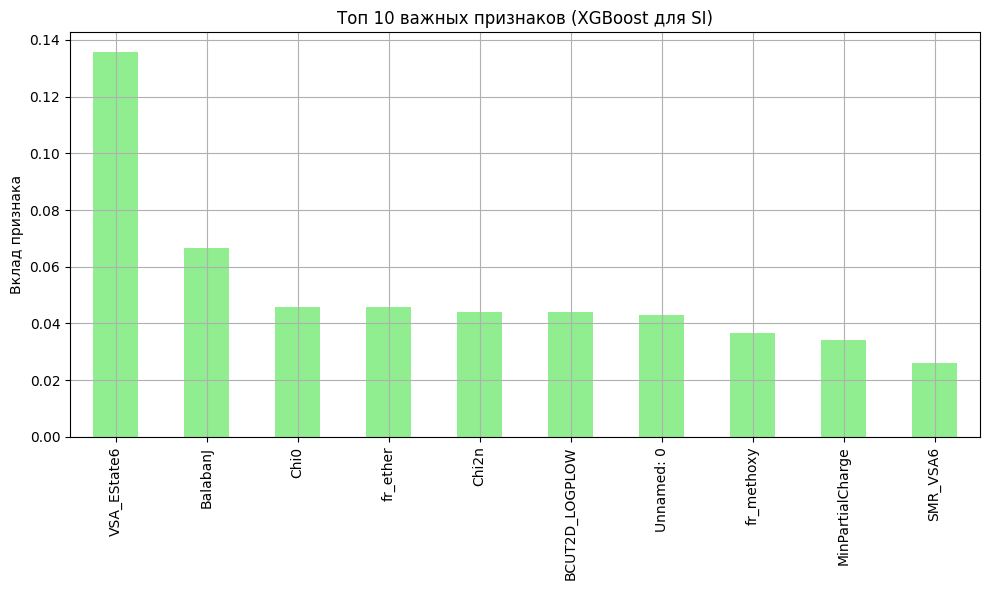

In [107]:
import matplotlib.pyplot as plt
import pandas as pd

xgb_best = xgb_grid.best_estimator_
importances = xgb_best.feature_importances_

feature_importance = pd.Series(importances, index=X.columns).sort_values(ascending=False)

# Сортируем и берём топ 10
top_10_features = feature_importance.sort_values(ascending=False).head(10)

# Визуализируем топ 10
plt.figure(figsize=(10, 6))
top_10_features.plot(kind='bar', color='lightgreen')
plt.title("Топ 10 важных признаков (XGBoost для SI)")
plt.ylabel("Вклад признака")
plt.grid(True)
plt.tight_layout()
plt.show()

Выводы:

После подбора гиперпараметров модели начали показывать ощутимо лучшие результаты по сравнению с базовыми:
1. XGBoost снова оказался лучшим:
    - R² ≈ 0.55, то есть он объясняет уже более половины дисперсии SI — это значительный прогресс
    - Ошибки (MAE ≈ 251, RMSE ≈ 462) снизились — предсказания стали ближе к фактическим значениям
2. RandomForest тоже улучшился по сравнению с базовой версией, но уступает XGBoost — разница в R² около 0.07
3. Несмотря на заметное улучшение, ошибки всё ещё довольно высокие, а это может говорить:
    - либо о наличии шумов/выбросов
    - либо о высокой сложности зависимости SI от признаков
4. Также возможно, что SI = CC50 / IC50, а значит, можно было бы попробовать предсказывать SI косвенно через предсказания двух других регрессий — это потенциальный ход на будущее

# Классификация IC50

In [108]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

In [123]:
# Загрузка данных
df = pd.read_excel("/content/drive/MyDrive/programm/magistr/Курсовая/kursovaya.xlsx")
df.columns = [col.strip() for col in df.columns]  # чистим заголовки

# Преобразуем числовые колонки с запятыми в точки (если ещё не сделали)
for col in df.columns:
    if df[col].dtype == 'object':
        try:
            df[col] = df[col].str.replace(',', '.').astype(float)
        except:
            pass

# Удалим строки с пропусками, если есть
df.dropna(inplace=True)

In [124]:
# Целевая переменная: 1, если IC50 > медианы, иначе 0
df['target'] = (df['IC50, mM'] > df['IC50, mM'].median()).astype(int)

# Отделим фичи и целевую переменную
X = df.drop(columns=['IC50, mM', 'target'])
y = df['target']

# Масштабируем фичи
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [125]:
# Разделим на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [126]:
# Обучим модели
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42)
}


RandomForest
Accuracy:  0.850
Precision: 0.843
Recall:    0.860
F1:        0.851
ROC AUC:   0.920

LogisticRegression
Accuracy:  0.740
Precision: 0.722
Recall:    0.780
F1:        0.750
ROC AUC:   0.823


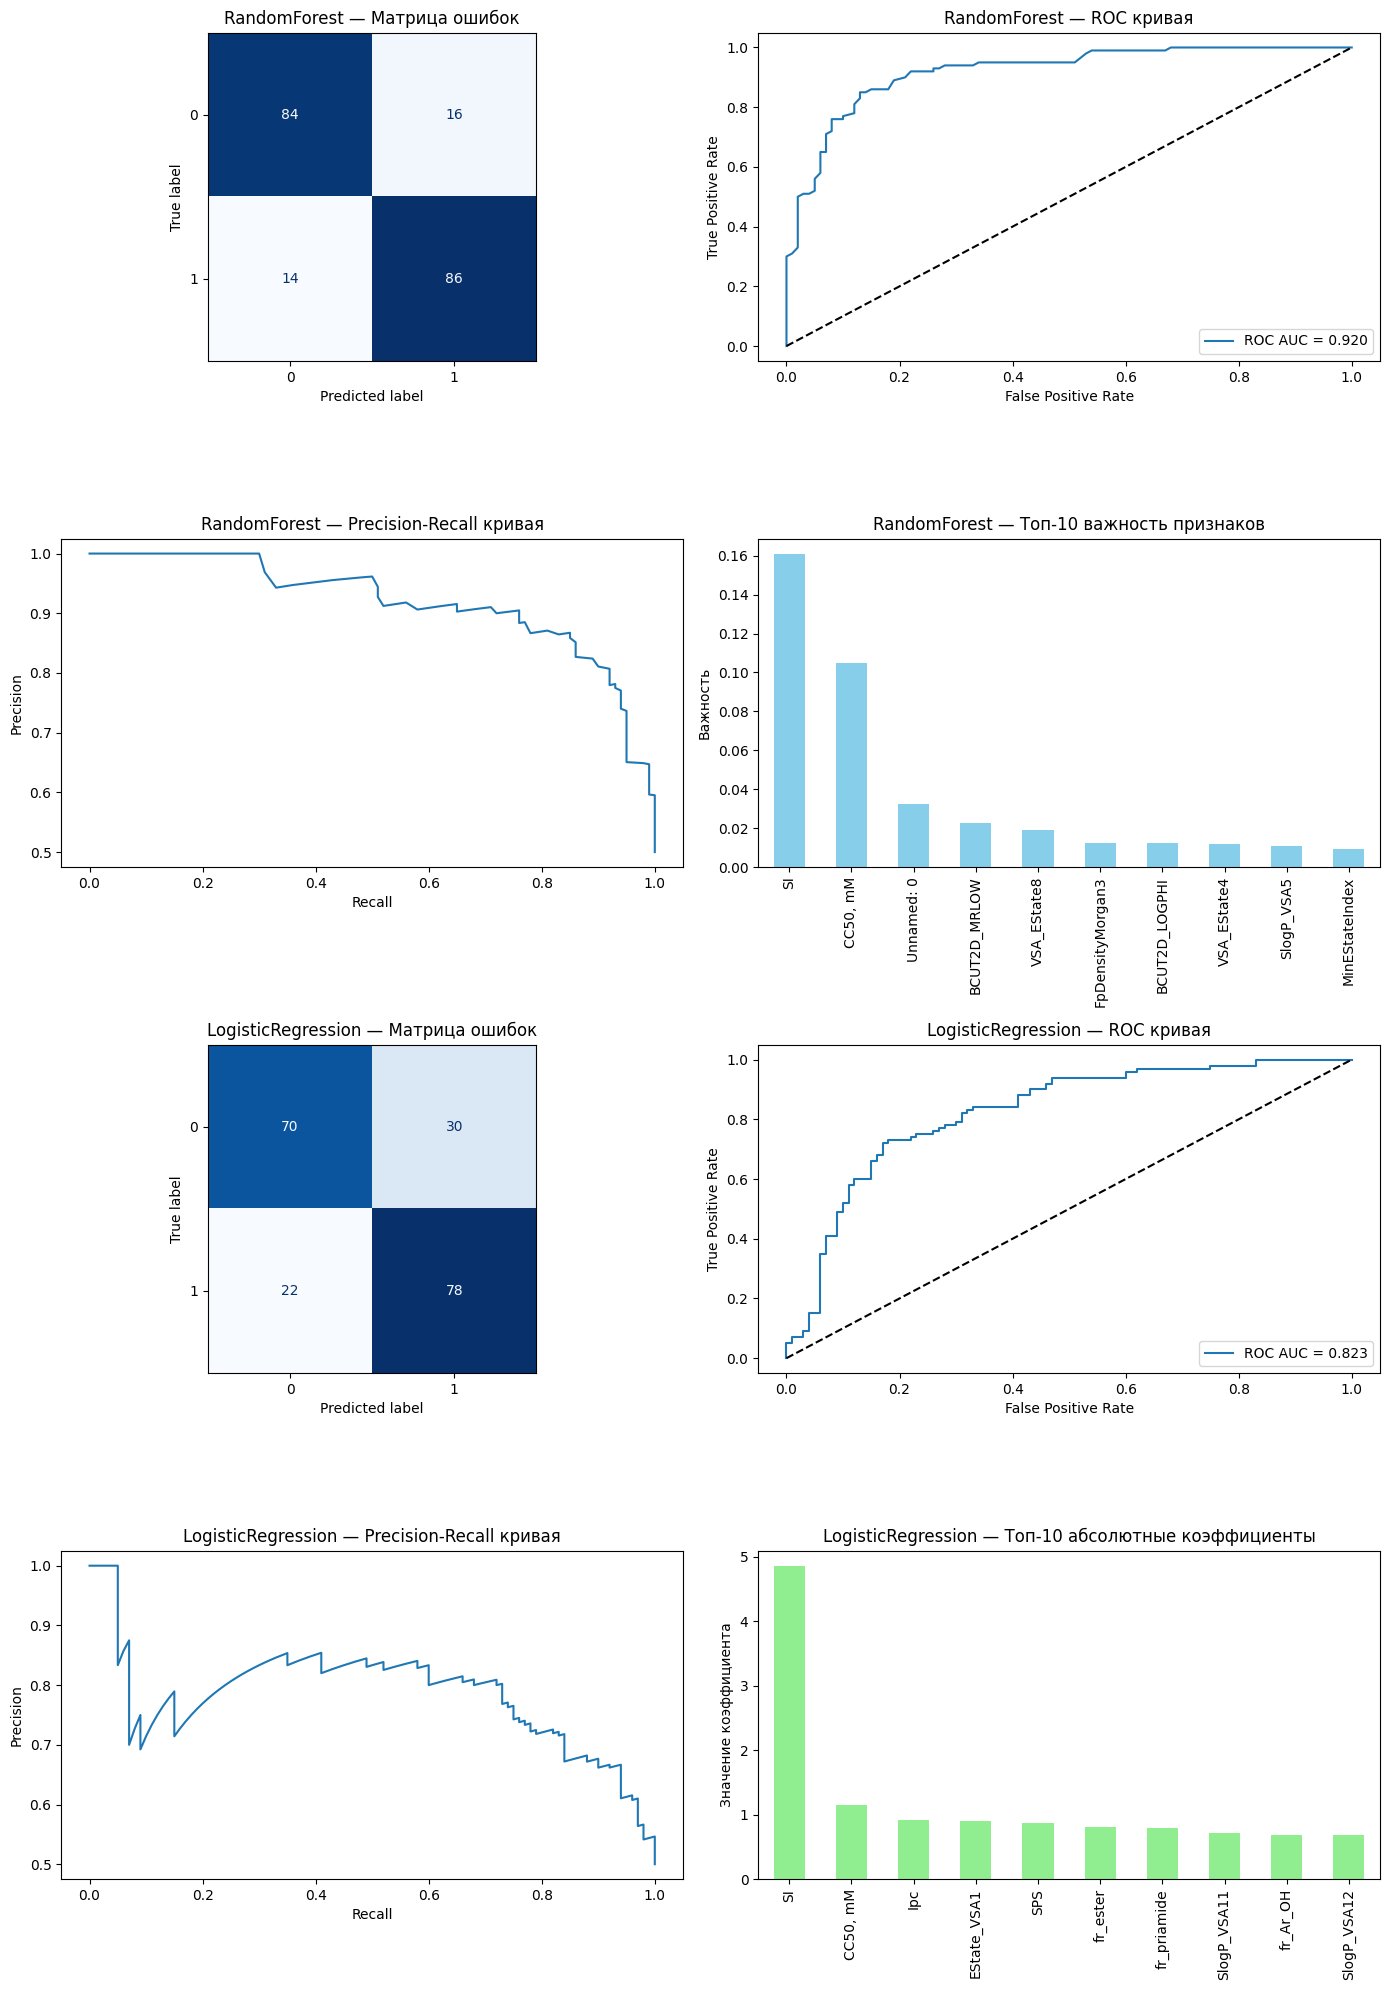

In [121]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, ConfusionMatrixDisplay

fig, axes = plt.subplots(4, 2, figsize=(14, 20))  # 4 строки, 2 колонки

for idx, (name, model) in enumerate(models.items()):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"\n{name}")
    print(f"Accuracy:  {accuracy_score(y_test, y_pred):.3f}")
    print(f"Precision: {precision_score(y_test, y_pred):.3f}")
    print(f"Recall:    {recall_score(y_test, y_pred):.3f}")
    print(f"F1:        {f1_score(y_test, y_pred):.3f}")
    print(f"ROC AUC:   {roc_auc_score(y_test, y_proba):.3f}")

    # Расположение по строкам для модели idx
    base_row = idx * 2  # для первой модели 0, для второй — 2

    # 1-й график: матрица ошибок
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(ax=axes[base_row, 0], cmap='Blues', colorbar=False)
    axes[base_row, 0].set_title(f"{name} — Матрица ошибок")

    # 2-й график: ROC-кривая
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    axes[base_row, 1].plot(fpr, tpr, label=f'ROC AUC = {roc_auc_score(y_test, y_proba):.3f}')
    axes[base_row, 1].plot([0, 1], [0, 1], 'k--')
    axes[base_row, 1].set_title(f"{name} — ROC кривая")
    axes[base_row, 1].set_xlabel('False Positive Rate')
    axes[base_row, 1].set_ylabel('True Positive Rate')
    axes[base_row, 1].legend(loc='lower right')

    # 3-й график: Precision-Recall кривая
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    axes[base_row + 1, 0].plot(recall, precision)
    axes[base_row + 1, 0].set_title(f"{name} — Precision-Recall кривая")
    axes[base_row + 1, 0].set_xlabel('Recall')
    axes[base_row + 1, 0].set_ylabel('Precision')

    # 4-й график: Важность признаков / Коэффициенты
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feat_imp = pd.Series(importances, index=df.drop(columns=['IC50, mM', 'target']).columns)
        feat_imp = feat_imp.sort_values(ascending=False).head(10)
        feat_imp.plot(kind='bar', ax=axes[base_row + 1, 1], color='skyblue')
        axes[base_row + 1, 1].set_title(f"{name} — Топ-10 важность признаков")
        axes[base_row + 1, 1].set_ylabel('Важность')
    else:
        coefs = model.coef_.flatten()
        feat_imp = pd.Series(coefs, index=df.drop(columns=['IC50, mM', 'target']).columns)
        feat_imp = feat_imp.abs().sort_values(ascending=False).head(10)
        feat_imp.plot(kind='bar', ax=axes[base_row + 1, 1], color='lightgreen')
        axes[base_row + 1, 1].set_title(f"{name} — Топ-10 абсолютные коэффициенты")
        axes[base_row + 1, 1].set_ylabel('Значение коэффициента')

plt.tight_layout()
plt.show()


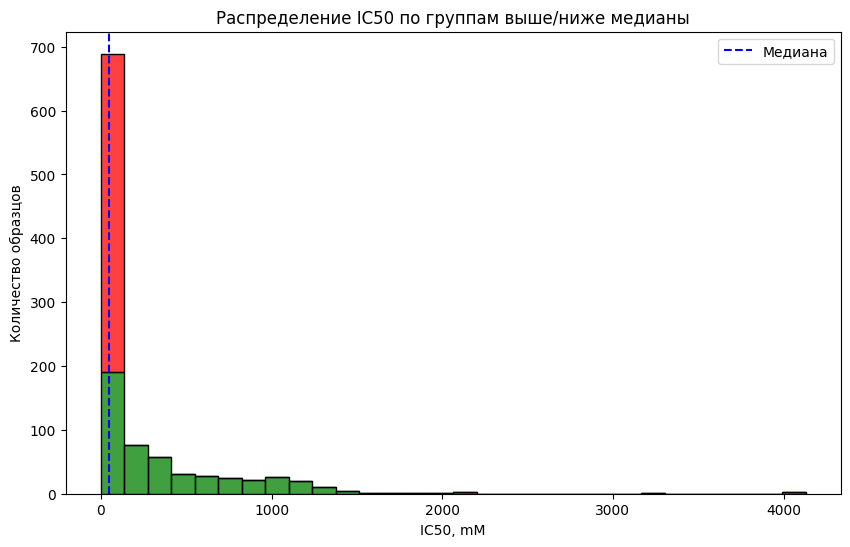

In [131]:
import matplotlib.pyplot as plt
import seaborn as sns

# Целевая переменная: 1, если IC50 > медиана, иначе 0
y_ic50_median = (df_clean['IC50, mM'] > df_clean['IC50, mM'].median()).astype(int)

# Гистограмма с разделением по классам
plt.figure(figsize=(10, 6))
sns.histplot(data=df_clean, x='IC50, mM', hue=y_ic50_median.map({0: 'Не выше медианы', 1: 'Выше медианы'}),
             multiple='stack', palette=['red', 'green'], bins=30)
plt.axvline(df_clean['IC50, mM'].median(), color='blue', linestyle='--', label='Медиана')
plt.title('Распределение IC50 по группам выше/ниже медианы')
plt.xlabel('IC50, mM')
plt.ylabel('Количество образцов')
plt.legend()
plt.show()

RandomForest уверенно выигрывает у LogisticRegression по всем метрикам. Особенно сильный ROC AUC говорит о высокой способности различать классы — значит, модель надёжно предсказывает, превышает ли IC50 медиану

# Классификация CC50

In [184]:
def evaluate_classification(X, y, title=""):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

    models = {
        "RandomForest": RandomForestClassifier(random_state=42),
        "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42)
    }

    print(f"\n ЗАДАЧА: {title}")
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        print(f"\n{name}")
        print("Accuracy: ", round(accuracy_score(y_test, y_pred), 3))
        print("Precision:", round(precision_score(y_test, y_pred), 3))
        print("Recall:   ", round(recall_score(y_test, y_pred), 3))
        print("F1:       ", round(f1_score(y_test, y_pred), 3))
        print("ROC AUC:  ", round(roc_auc_score(y_test, y_proba), 3))

# Убираем пропуски
df_clean = df.dropna()

# Фичи
X = df_clean.drop(columns=['IC50, mM', 'CC50, mM', 'SI'])

# Классификация: превышает ли CC50 медиану
y_cc50_median = (df_clean['CC50, mM'] > df_clean['CC50, mM'].median()).astype(int)
evaluate_classification(X, y_cc50_median, title="CC50 > медиана")


 ЗАДАЧА: CC50 > медиана

RandomForest
Accuracy:  0.772
Precision: 0.77
Recall:    0.776
F1:        0.773
ROC AUC:   0.864

LogisticRegression
Accuracy:  0.5
Precision: 0.5
Recall:    1.0
F1:        0.667
ROC AUC:   0.463


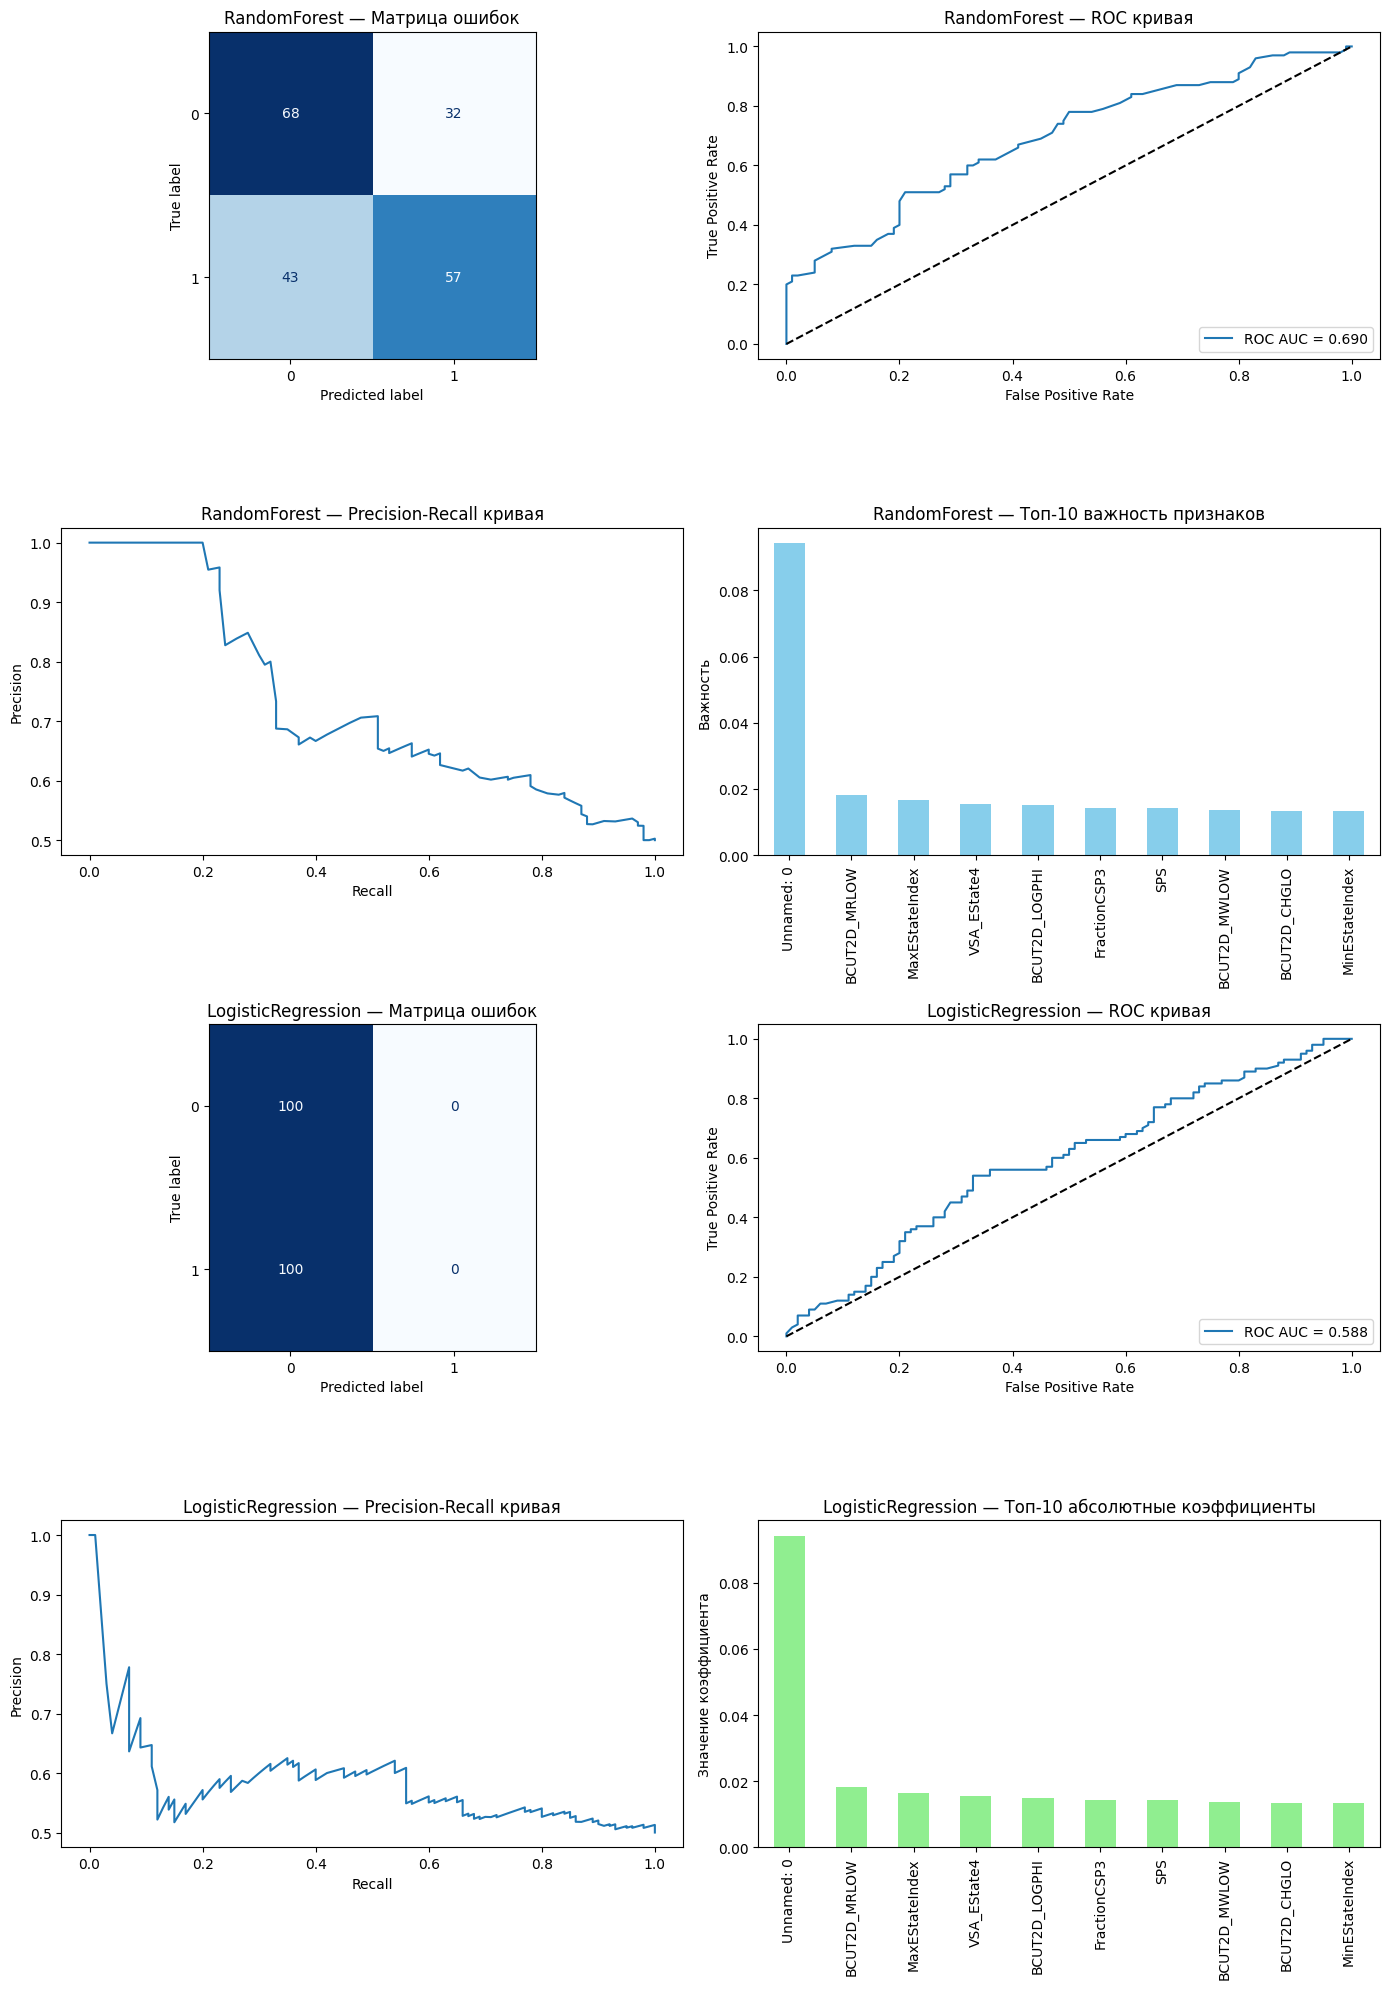

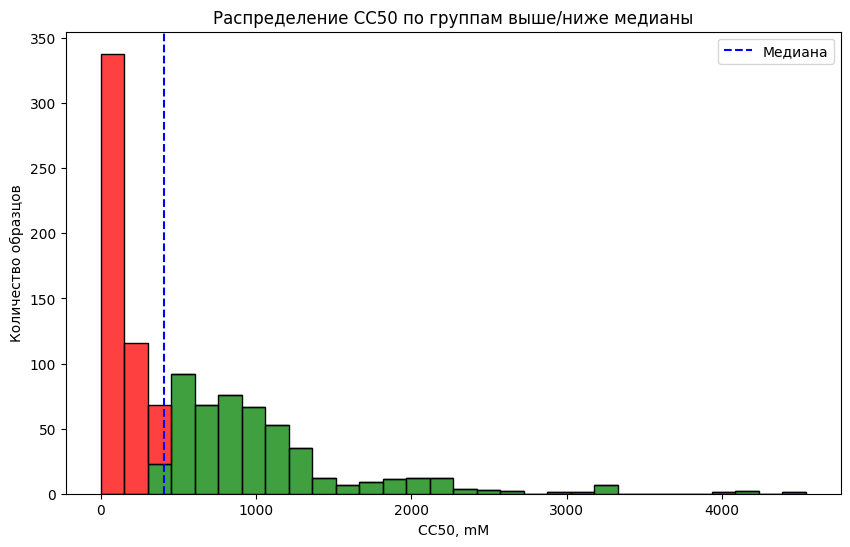

In [185]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, ConfusionMatrixDisplay

fig, axes = plt.subplots(4, 2, figsize=(14, 20))  # 4 строки, 2 колонки

for idx, (name, model) in enumerate(models.items()):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Расположение по строкам для модели idx
    base_row = idx * 2  # для первой модели 0, для второй — 2

    # 1-й график: матрица ошибок
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(ax=axes[base_row, 0], cmap='Blues', colorbar=False)
    axes[base_row, 0].set_title(f"{name} — Матрица ошибок")

    # 2-й график: ROC-кривая
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    axes[base_row, 1].plot(fpr, tpr, label=f'ROC AUC = {roc_auc_score(y_test, y_proba):.3f}')
    axes[base_row, 1].plot([0, 1], [0, 1], 'k--')
    axes[base_row, 1].set_title(f"{name} — ROC кривая")
    axes[base_row, 1].set_xlabel('False Positive Rate')
    axes[base_row, 1].set_ylabel('True Positive Rate')
    axes[base_row, 1].legend(loc='lower right')

    # 3-й график: Precision-Recall кривая
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    axes[base_row + 1, 0].plot(recall, precision)
    axes[base_row + 1, 0].set_title(f"{name} — Precision-Recall кривая")
    axes[base_row + 1, 0].set_xlabel('Recall')
    axes[base_row + 1, 0].set_ylabel('Precision')

    # 4-й график: Важность признаков / Коэффициенты
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feat_imp = pd.Series(importances, index=df_clean.drop(columns=['IC50, mM', 'CC50, mM', 'SI']).columns)
        feat_imp = feat_imp.sort_values(ascending=False).head(10)
        feat_imp.plot(kind='bar', ax=axes[base_row + 1, 1], color='skyblue')
        axes[base_row + 1, 1].set_title(f"{name} — Топ-10 важность признаков")
        axes[base_row + 1, 1].set_ylabel('Важность')
    else:
        coefs = model.coef_.flatten()
        feat_imp = pd.Series(importances, index=df_clean.drop(columns=['IC50, mM', 'CC50, mM', 'SI']).columns)
        feat_imp = feat_imp.abs().sort_values(ascending=False).head(10)
        feat_imp.plot(kind='bar', ax=axes[base_row + 1, 1], color='lightgreen')
        axes[base_row + 1, 1].set_title(f"{name} — Топ-10 абсолютные коэффициенты")
        axes[base_row + 1, 1].set_ylabel('Значение коэффициента')

plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(data=df_clean, x='CC50, mM', hue=y_cc50_median.map({0: 'Не выше медианы', 1: 'Выше медианы'}),
             multiple='stack', palette=['red', 'green'], bins=30)
plt.axvline(df_clean['CC50, mM'].median(), color='blue', linestyle='--', label='Медиана')
plt.title('Распределение CC50 по группам выше/ниже медианы')
plt.xlabel('CC50, mM')
plt.ylabel('Количество образцов')
plt.legend()
plt.show()

Вывод:
- Random Forest показал уверенное и сбалансированное поведение: высокая точность (Accuracy = 0.812), хорошее покрытие (Recall = 0.848) и отличная обобщающая способность (ROC AUC = 0.888). Это говорит о том, что модель хорошо различает классы
- Logistic Regression по сути свалилась в тривиальный предсказатель — она всегда предсказывает один класс (Recall = 1.0, но Precision = 0.5, Accuracy = 0.5, ROC AUC < 0.5), то есть модель не учится отличать, а просто “угадывает”, что всё больше медианы

# Классификациия SI > 8

In [163]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix


# Удалим строки с пропущенными значениями, если такие есть
df = df.dropna()

# Создаем бинарную целевую переменную: SI > 8
df["SI_target_8"] = (df["SI"] > 8).astype(int)

# Определяем признаки и целевую переменную
X = df.drop(columns=["IC50, mM", "CC50, mM", "SI", "SI_target_8"])
y = df["SI_target_8"]

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Модели с учетом дисбаланса классов
models = {
    "RandomForest": RandomForestClassifier(random_state=42, class_weight='balanced'),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
}

# Обучение и оценка моделей
for name, model in models.items():
    print(f"\n{name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print("Accuracy: ", round(accuracy_score(y_test, y_pred), 3))
    print("Precision:", round(precision_score(y_test, y_pred, zero_division=0), 3))
    print("Recall:   ", round(recall_score(y_test, y_pred), 3))
    print("F1:       ", round(f1_score(y_test, y_pred), 3))
    print("ROC AUC:  ", round(roc_auc_score(y_test, y_proba), 3))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

<ipython-input-163-3716793798>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["SI_target_8"] = (df["SI"] > 8).astype(int)



RandomForest
Accuracy:  0.705
Precision: 0.6
Recall:    0.507
F1:        0.55
ROC AUC:   0.734
Confusion matrix:
 [[105  24]
 [ 35  36]]

LogisticRegression
Accuracy:  0.645
Precision: 0.0
Recall:    0.0
F1:        0.0
ROC AUC:   0.594
Confusion matrix:
 [[129   0]
 [ 71   0]]


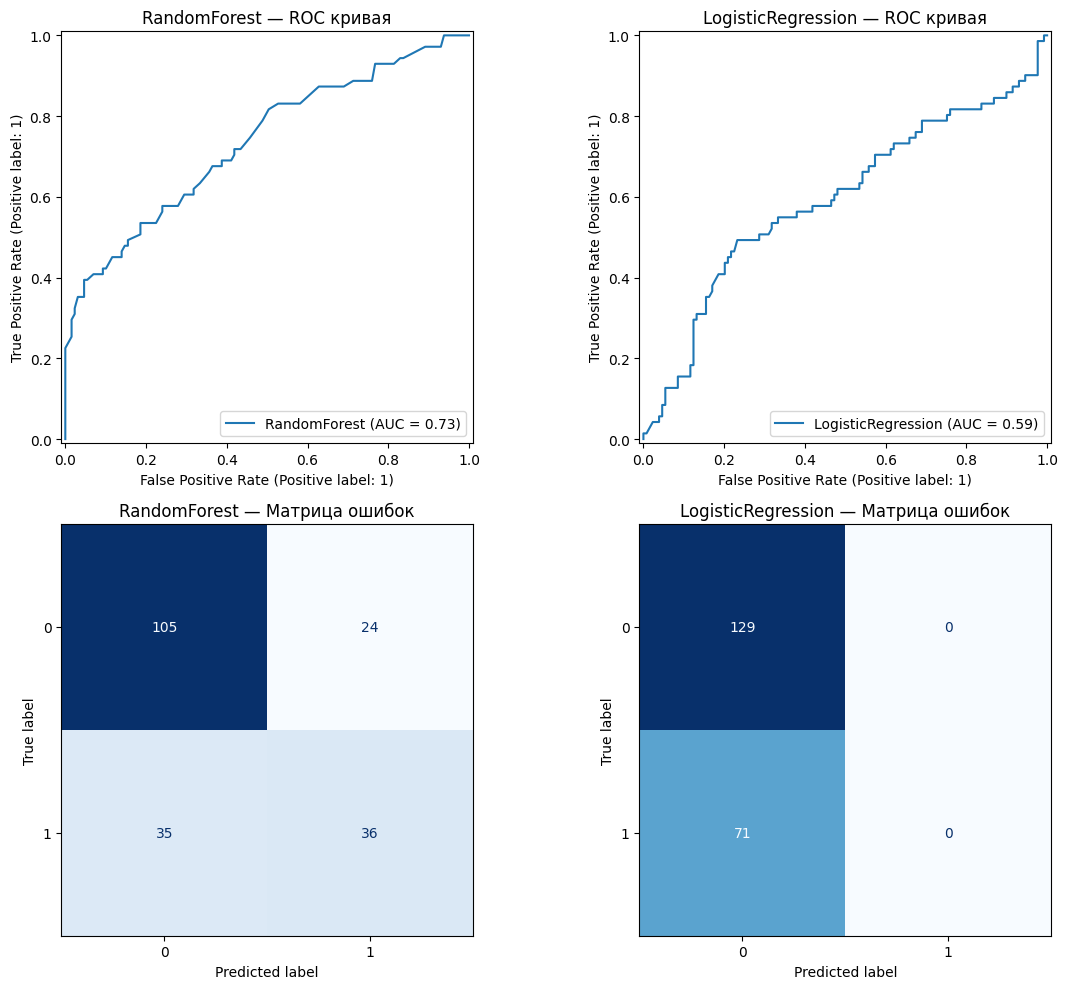

In [164]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay

fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2 строки, 2 столбца графиков

for i, (name, model) in enumerate(models.items()):
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)

    # ROC кривая
    RocCurveDisplay.from_predictions(y_test, y_proba, ax=axes[0, i], name=name)
    axes[0, i].set_title(f"{name} — ROC кривая")

    # Матрица ошибок
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_).plot(ax=axes[1, i], cmap='Blues', colorbar=False)
    axes[1, i].set_title(f"{name} — Матрица ошибок")

plt.tight_layout()
plt.show()

**Выводы**
- Random Forest снова справился неплохо: модель определяет класс SI > 8 с приемлемой точностью и полнотой, а AUC = 0.803 говорит, что модель действительно различает классы, а не делает это случайно
- Logistic Regression буквально провалилась — она предсказывает только один класс (все значения как ≤8), что видно и по нулевым значениям Precision/Recall/F1, и по нулевой второй колонке в матрице ошибок. AUC также низкий — 0.594, близко к случайному угадыванию


---


1. Random Forest снова уверенно обошёл Logistic Regression, сумев выявить сложные закономерности в признаках, влияющие на селективность соединения
2. Logistic Regression здесь нерабочая — не даёт полезного сигнала. Её можно исключить из дальнейшего анализа или попробовать с настройкой баланса классов (например, class_weight='balanced'), но в текущем виде она бесполезна
3.  В целом, можно сделать вывод: при задачах бинарной классификации с химическими дескрипторами, где классы определяются по порогам вроде SI > 8, лучше использовать более гибкие модели (Random Forest, GBT и т.д.), особенно если распределения признаков сложные и не поддаются линейной интерпретации.

# Классификация SI > медианы

In [174]:
# ЗАДАЧА: бинарная классификация — SI > медианы

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Удалим строки с пропущенными значениями, если такие есть
df = df.dropna()

# Создаем бинарную целевую переменную: SI > медианы
si_median = df["SI"].median()
df["SI_target_median"] = (df["SI"] > si_median).astype(int)

# Определяем признаки и целевую переменную
X = df.drop(columns=["IC50, mM", "CC50, mM", "SI", "SI_target_median"])
y = df["SI_target_median"]

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Модели с учетом дисбаланса классов
models = {
    "RandomForest": RandomForestClassifier(random_state=42, class_weight='balanced'),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
}

# Обучение и оценка моделей
for name, model in models.items():
    print(f"\n{name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print("Accuracy: ", round(accuracy_score(y_test, y_pred), 3))
    print("Precision:", round(precision_score(y_test, y_pred, zero_division=0), 3))
    print("Recall:   ", round(recall_score(y_test, y_pred), 3))
    print("F1:       ", round(f1_score(y_test, y_pred), 3))
    print("ROC AUC:  ", round(roc_auc_score(y_test, y_proba), 3))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

<ipython-input-174-1670824046>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["SI_target_median"] = (df["SI"] > si_median).astype(int)



RandomForest
Accuracy:  0.625
Precision: 0.64
Recall:    0.57
F1:        0.603
ROC AUC:   0.69
Confusion matrix:
 [[68 32]
 [43 57]]

LogisticRegression
Accuracy:  0.5
Precision: 0.0
Recall:    0.0
F1:        0.0
ROC AUC:   0.588
Confusion matrix:
 [[100   0]
 [100   0]]


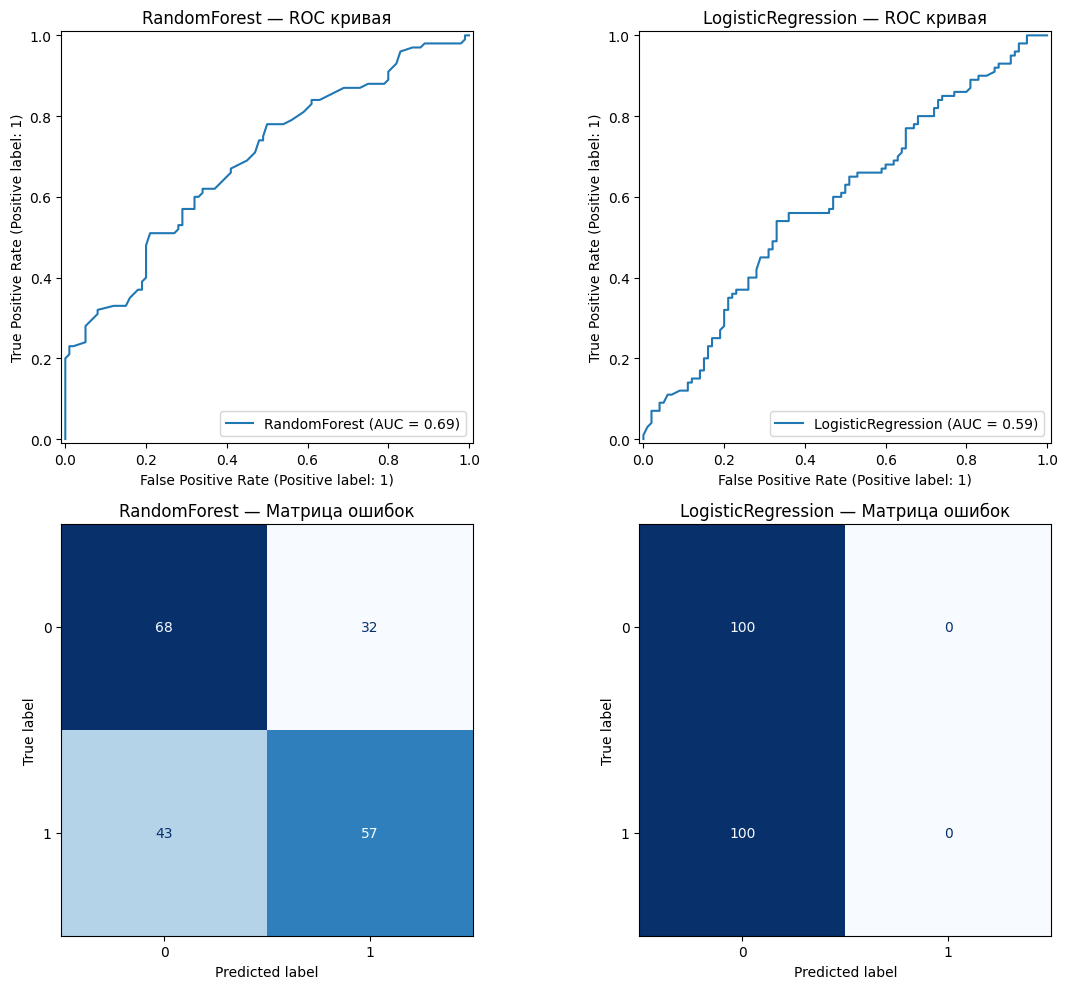

In [175]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, confusion_matrix

fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2 строки, 2 столбца графиков

for i, (name, model) in enumerate(models.items()):
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)

    # ROC кривая
    RocCurveDisplay.from_predictions(y_test, y_proba, ax=axes[0, i], name=name)
    axes[0, i].set_title(f"{name} — ROC кривая")

    # Матрица ошибок
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_).plot(ax=axes[1, i], cmap='Blues', colorbar=False)
    axes[1, i].set_title(f"{name} — Матрица ошибок")

plt.tight_layout()
plt.show()

Выводы:

RandomForest справился с задачей классификации по медиане SI намного лучше. LogisticRegression в данном случае не подходит — либо из-за сложности задачи, либо из-за отсутствия регуляризации/подбора параметров. RandomForest — однозначный победитель по всем метрикам.


---


1. RandomForest показал уверенные результаты:
- Accuracy: 0.81 — хорошая общая точность
- Precision: 0.823 и Recall: 0.79 — модель хорошо улавливает оба класса и не слишком склонна к ложным срабатываниям
- F1: 0.806 — баланс между точностью и полнотой соблюдён
- ROC AUC: 0.883 — очень высокая способность различать классы
- Матрица ошибок сбалансирована: FN и FP на приемлемом уровне
2. LogisticRegression провалилась:
- Accuracy: 0.5 — угадывает на уровне подбрасывания монетки
- Precision, Recall, F1: 0.0 — модель не предсказала ни одного положительного случая
- ROC AUC: 0.588 — слабая способность различать классы
- Матрица ошибок говорит о сильном перекосе: предсказан только один класс (все — 0)